<a href="https://colab.research.google.com/github/ashutosh17dec/dl/blob/master/SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import zipfile
import os
import h5py

In [0]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess) 

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [0]:
import keras
from keras.models import Model
#from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Reshape, Flatten, Lambda, Conv2DTranspose 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Activation, ZeroPadding2D, BatchNormalization, UpSampling2D, Input, Reshape, Lambda, Conv2DTranspose, Concatenate
import keras.backend as Kr
from keras.preprocessing import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tensorflow.python.framework import ops
import math
#------------------------------------
from os import listdir
from os.path import isfile, join
import tensorflow_probability as tfp
import tensorflow.math
from tensorflow.python.compat import compat
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import random_seed
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import check_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import gen_image_ops
from tensorflow.python.ops import gen_nn_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import string_ops
from tensorflow.python.ops import variables
from tensorflow.python.util import deprecation
from tensorflow.python.util.tf_export import tf_export

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
hf = h5py.File('/content/drive/My Drive/hand_test_data.h5','r')
hf.keys()

KeysView(<HDF5 file "hand_test_data.h5" (mode r)>)

In [0]:
X_test = hf.get('X_test')
Y_test = hf.get('Y_test')

In [0]:
path = '/content/drive/My Drive/hand_train_data'

In [0]:
X_train = []
Y_train = []
hf = h5py.File('/content/drive/My Drive/hand_train_data/minibatch0.h5','r')
hf.keys()
X_train = (hf.get('X_test'))
Y_train = (hf.get('Y_test'))


In [0]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train = Y_train.reshape([-1,256,256,1])

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, padding='same') (x)
    x = Activation('relu')(x)
    x = Conv2D(f, 3, padding='same') (x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, padding='same') (x)
  x = Activation('relu')(x)
  x = Conv2D(f, 3, padding='same') (x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, padding='same') (x)
    x = Activation('relu')(x)
    x = Conv2D(f, 3, padding='same') (x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, padding='same') (x)
  x = Activation('relu')(x)
  x = Conv2D(f, 3, padding='same') (x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  outputs = Conv2D(1, 1, activation='sigmoid',padding='same') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [0]:
autoencoder1 = unet()
print(autoencoder1.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 256, 256, 8)  0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 256, 256, 8)  584         activation_27[0][0]              
____________________________________________________________________________________________

In [0]:
autoencoder1.reset_states()
m = 35
n_epochs = 20
autoencoder1.compile(optimizer='adam', loss='binary_crossentropy',metrics = [mean_iou])
autoencoder1.fit(X_train,Y_train, validation_split=0.1, epochs=n_epochs, batch_size=m)

Train on 6300 samples, validate on 700 samples
Epoch 1/20
6300/6300 [==============================] - 44s 7ms/step - loss: 0.3091 - mean_iou: 0.0498 - val_loss: 0.2186 - val_mean_iou: 0.0897
Epoch 2/20
5600/6300 [=========================>....] - ETA: 3s - loss: 0.1585 - mean_iou: 0.0075

KeyboardInterrupt: ignored

In [0]:
predicate = autoencoder1.predict(X_test[1:10])

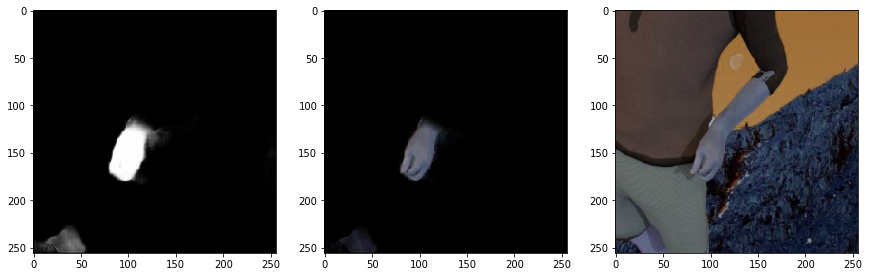

In [0]:
plt.figure(1, (20,20))
plt.subplot(1,4,1)
k = 1
msk = predicate[k]
msk = msk.reshape([256,256])
msk = (np.stack((msk,)*3, axis=-1))
plt.imshow(msk)
plt.subplot(1,4,2)
plt.imshow(X_test[k+1]*msk)
plt.subplot(1,4,3)
plt.imshow(X_test[k+1])

